In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container {width: 100%; important! }</style>"))
import numpy as np
import pyaudio
%matplotlib inline
from matplotlib import pyplot as plt
import wave
import time

In [191]:
FORMAT = pyaudio.paInt16
SAMPLE_WIDTH=2
NUMPY_ARR = np.int16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
audio = pyaudio.PyAudio()
DURATION = 0.1

In [148]:
def record_mic(seconds=5):
    frames = []
    stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
    for i in range(0, int(RATE / CHUNK * seconds)):
        data = stream.read(CHUNK)
        frames.append(data)
    data_str = (b"").join(frames)
    return np.frombuffer(data_str, dtype=NUMPY_ARR)

def gen_sound(np_arr, play=False, saveto=None):
    data = np_arr.astype("int16").tobytes()
    if saveto is not None:
        f = wave.open(saveto, "wb")
        f.setnchannels(CHANNELS)
        f.setsampwidth(SAMPLE_WIDTH)
        f.setframerate(RATE)
        f.writeframes(data)
        f.close()
    if play:
        stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, output=True)
        for i in range(0, len(data), CHUNK):
            chunk = data[i: i + CHUNK]
            stream.write(chunk)

def sleep(seconds):
    time.sleep(seconds)

def gen_time(seconds=5):
    return np.arange(0, seconds, 1./RATE)

def gen_sin(freq=440, seconds=5):
    x = gen_time(seconds=seconds)
    return np.sin(2*np.pi*x*freq)

def gen_saw(freq=440, seconds=5, symmetry=1.):
    period = 1./freq
    frame_samples = RATE*period
    frame_samples_int = int(frame_samples)
    separator_int = int(frame_samples * symmetry)
    x = gen_time(seconds)
    value = 0.*x[:frame_samples_int]
    value[:separator_int] = 2 * x[:separator_int] / x[separator_int - 1] - 1
    value[separator_int:] = 2 * (period - x[separator_int:frame_samples_int])/(period - x[separator_int]) - 1
    value = np.expand_dims(value, axis=0)
    return np.squeeze(np.hstack((int(seconds*freq) + 1)*[value]))[:len(x)]

def plot_sound(x, y, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    ax.plot(x, y)
    ax.set_xlabel("time, $s$")
    ax.set_ylabel("amplitude")
    
def advanced_plot(dct, *signal_names, frames=None):
    x = dct["time"][:frames]
    ys = [dct[i][:frames] for i in signal_names]
    plot_sound(x, np.vstack(ys).T)

In [192]:
mixture_matrix = np.array([[2.1, 1], [1.2, 1.7]])
signals = dict(time=gen_time(DURATION), sine=gen_sin(220, DURATION), saw=gen_saw(50*np.pi, DURATION, 0.8))
signals["initial"] = np.vstack([signals["saw"], signals["sine"]])
signals["mixture"] = mixture_matrix @ signals["initial"]
signals["unmixed"] = np.linalg.inv(mixture_matrix) @ signals["mixture"]

In [193]:
signals["initial"].shape

(2, 4410)

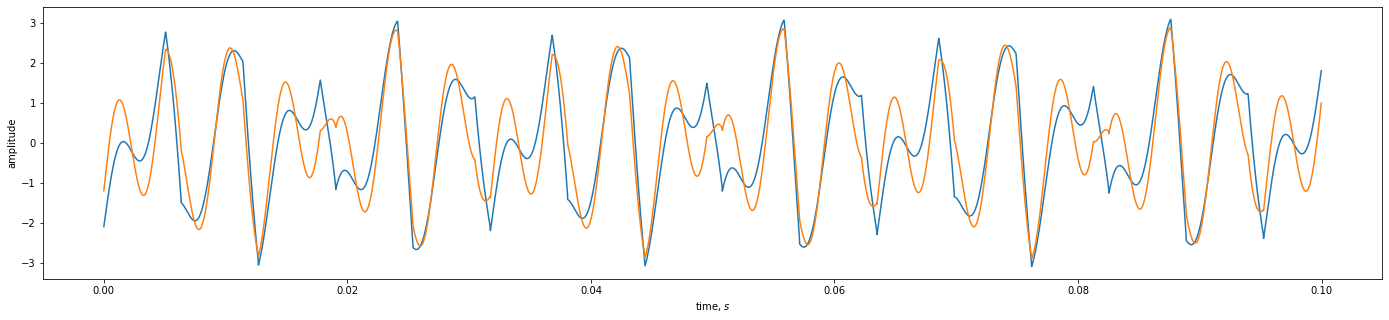

In [194]:
plot_sound(signals["time"], signals["mixture"].T)

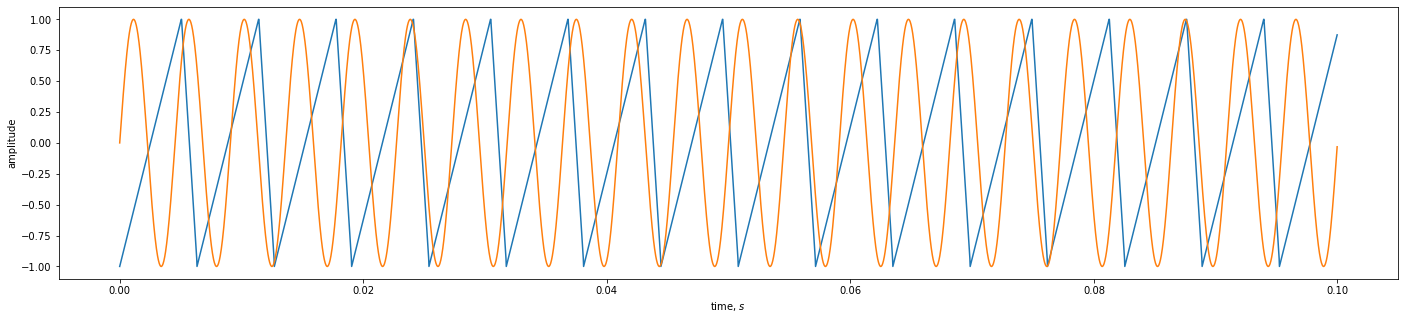

In [195]:
plot_sound(signals["time"], signals["unmixed"].T)

## Preprocessing

In [196]:
def center(signal):
    return signal - np.expand_dims(signal.mean(axis=1), axis=1)

def white(signal):
    matrix = np.cov(signal)
    w, E = np.linalg.eig(matrix)
    wsq = np.sqrt(w)
    D = np.diag(wsq)
    M = E @ D @ E.T
    return M @ signal

def preprocess(signal):
    return white(center(signal))

In [197]:
signals["preprocessed"] = preprocess(signals["mixture"])

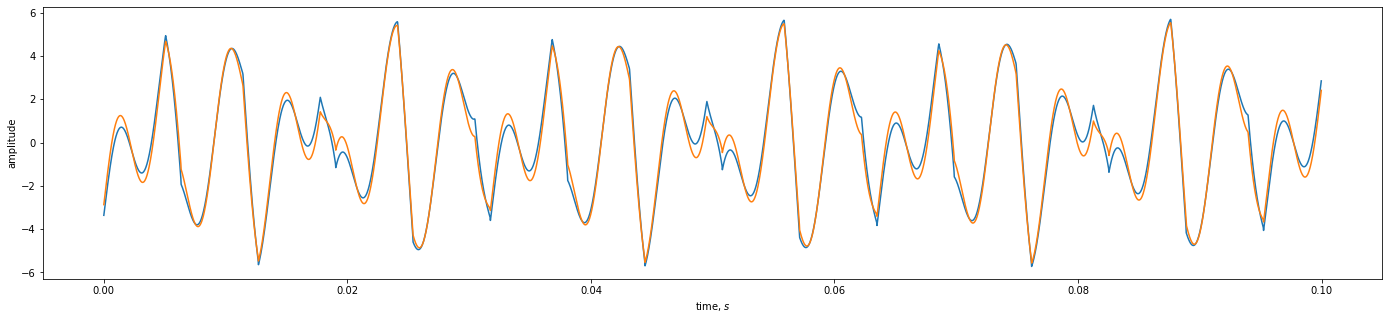

In [198]:
plot_sound(signals["time"], signals["preprocessed"].T)